## 1. __ENVIROMENT__

### 1.1 __BIBLIOTECAS__

Para o bom funcionamento do notebook as seguintes bibliotecas são necessárias
- ```numpy:``` Utilizado nas operações envolvendo vetores e matrizes
- ```pandas:``` Utilizado para ler e escrever os arquivos em formato de Dataframe
- ```matplotlib.pyplot:``` Utilizado para a construção de gráficos
- ```spicy.spatial:``` Utilizado para operações de distância
  - ```distance:``` Módulo usado para importar a função *euclidean* para calcular a distância euclidiana
- ```os:``` Utilizado para manipulação de diretórios
- ```sklearn.metrics:``` Utilizado para a análise das partições

In [1]:
# Bibliotecas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.spatial as sp
from scipy.spatial.distance import euclidean
import os
import sklearn.metrics as sl

### __1.2 FUNÇÕES__ 

#### ```colorize(data)```
Utilizada para atribuir cor para cada cluster distinto no conjunto
- ```Parâmetros:```
  - data: conjunto de dados que representam a qual cluster aquela amostra pertence
- ```Saída:``` vetor com cores 

#### ```load_dataset(dataset_name, ext, skips)```
Utilizada para ler um dataset
- ```Parâmetros:```
  - dataset_name: nome do arquivo que contêm as amostras
  - ext: extensão do arquivo
  - skips: quantidade de linhas que devem ser puladas (útil quando o arquivo possui header)
- ```Saída:``` dataframe do arquivo

#### ```plot_multiple_datasets(datasets, nrows, ncols, cluster_labels, suptitle)```
Utilizada para plotar os gráficos a partir de vários datasets e suas respectivas partições
- ```Parâmetros:```
  - datasets: conjunto de dataframes que representam as amostras e seus atributos
  - nrows: número de linhas que devem ser usadas ni gráfico
  - ncols: número de colunas que devem ser usadas ni gráfico
  - cluster_labels: conjunto de dataframes que representam os clusters aos quais as amostras pertencem
  - suptitle: título do gráfico
  
#### ```plot_multiple_partitions(dataset, cluster_labels, nrows, ncols, suptitle)```
Utilizada para plotar os gráficos a partir de várias partições de um único dataset
- ```Parâmetros:```
  - dataset: um dataframe que representa as amostras e seus atributos
  - nrows: número de linhas que devem ser usadas ni gráfico
  - ncols: número de colunas que devem ser usadas ni gráfico
  - cluster_labels: conjunto de dataframes que representam os clusters aos quais as amostras pertencem
  - suptitle: título do gráfico
  
#### ```nova_coluna(id, dataframeT)```
Utilizada para, através das amostras contidas no corte do dendograma, linkar cada uma delas com seu respectivo cluster em formato de número
- ```Parâmetros:```
  - id: 
  - dataframeT:  
- ```Saída:``` 
  
#### ```atualiza_distancias(distancias, juntar_cluster, isSingle)```
Utilizada para manipular as distancias dos algoritmos hierárquicos
- ```Parâmetros:```
  - distancias: matriz que contêm as distâncias
  - juntar_cluster: tupla contendo o índice dos dois clusters que serão unidos
  - isSigle: usado para saber se o algorimto é single link ou não
- ```Saída:``` matriz de distâncias atualizada (com a união dos clusters)
  
#### ```rand(df1, df2)```
Utilizada para calcular e printar o valor do RAND
- ```Parâmetros:```
  - df1: lista contendo todos os dataframes dos arquivos das partições feitas
  - df2: dataframe base contendo a partição real para o cálculo de RAND

In [23]:
def colorize(data):
    color_palette = ['#910101', '#036CD7', '#078F8F', '#000000', '#FDFD6F', '#B16FFD', '#22FF25',
                     '#074752', '#8F4A00', '#FE6FB5', '#6BB6FE', '#DF6B00', '#48018D', '#FCB5DA']
    labels = np.unique(data)
    if len(labels) > len(color_palette):
        color_palette += ["#%06x" % c for c in np.random.randint(0, 0xFFFFFF, len(labels)-len(color_palette))]
    color_array = np.empty(data.shape, dtype=object)
    for label, color in zip(labels, color_palette):
        color_array[np.where(data==label)] = color
    return color_array


def load_dataset(dataset_name, ext, skips):
    dataset = pd.read_csv(os.path.join('dados_e_planilha/datasets/', dataset_name + ext), sep='\t', skiprows=skips, header=None)
    dataset.name = dataset_name
    return dataset


def plot_multiple_datasets(datasets, nrows, ncols, cluster_labels=None, suptitle=None):
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(min(5*ncols, 12), 3*nrows), constrained_layout=True)
    ax = ax.flatten()
    for i, dataset in enumerate(datasets):
        clusters = cluster_labels[i][cluster_labels[i].columns[1]]
        ax[i].scatter(dataset[dataset.columns[1]], dataset[dataset.columns[2]], s=10, c=colorize(clusters))
        ax[i].set_title('{0} - {1} clusters'.format(datasets[i].name, len(np.unique(clusters))))
        ax[i].tick_params(which='both', bottom=False, left=False, labelbottom=False, labelleft=False)
    if suptitle is not None:
        fig.suptitle(suptitle, fontsize=16)
    plt.show()


def plot_multiple_partitions(dataset, cluster_labels, nrows, ncols, suptitle=None):
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(min(5*ncols, 12), 3*nrows), constrained_layout=True)
    ax = ax.flatten()
    for i, cluster in enumerate(cluster_labels):
        clusters = cluster_labels[i][cluster_labels[i].columns[1]]
        ax[i].scatter(dataset[dataset.columns[1]], dataset[dataset.columns[2]], s=10, c=colorize(clusters))
        ax[i].set_title('{0} - {1} clusters'.format(dataset.name, len(np.unique(clusters))))
        ax[i].tick_params(which='both', bottom=False, left=False, labelbottom=False, labelleft=False)
    if suptitle is not None:
        fig.suptitle(suptitle, fontsize=16)
    plt.show()
    
    
def nova_coluna(id, dataframeT):
    for id_coluna, linha in dataframeT.iterrows():
        centroid_indices = list(map(int, linha['partition'].split(',')))
        if id in centroid_indices:
            return id_coluna


def atualiza_distancias(distancias, juntar_cluster, isSingle):
    # Atualiza as distâncias do novo cluster (juntar_cluster[0]) com todos os outros clusters
    if (isSingle == 1):
        #A matriz distancias agora terá 2 clusters(objetos) sendo agrupados
        #Assim, as distâncias anteriores entre os pontos devem ser atualizadas para ser a menor distância entre os clusters novos e antigos
        #Por exemplo, se os clusters 2 e 5 serão unidos, todos os objetos do 5 serão agora do cluster 2
        #As novas distâncias entre o cluster 2 e os outros clusters será a menor distância entre o cluster 2 e os outros clusters ou o cluster 5 e os outros clusters.
        distancias[juntar_cluster[0], :] = np.minimum(distancias[juntar_cluster[0], :], distancias[juntar_cluster[1], :])
    else:
        distancias[juntar_cluster[0], :] = np.maximum(distancias[juntar_cluster[0], :], distancias[juntar_cluster[1], :])

    distancias[:, juntar_cluster[0]] = distancias[juntar_cluster[0], :]
    np.fill_diagonal(distancias, np.inf)
    return (distancias)


def rand (df1, df2):
    k=0
    dfBase = pd.read_csv(f'dados_e_planilha/datasets/{df2}', sep='\t',header=None, names=['Sample', 'A1'], skiprows=0)

    if (df2.startswith('monkey')):
        for i in range (5,13):
            df1_k = df1[k]
            print(f"O índice Rand ajustado de {i} clusters comparado com {df2} é {sl.adjusted_rand_score(df1_k[1],dfBase['A1'])}")
            k=k+1

    else:
        for i in range (2,6):
            df1_k = df1[k]
            print(f"O índice Rand ajustado de {i} clusters comparado com {df2} é {sl.adjusted_rand_score(df1_k[1],dfBase['A1'])}")
            k=k+1

### __1.3 DADOS BASE__

- ```c2ds1-2sp:``` dados encadeados em forma de espiral
- ```c2ds3-2g```: dados baseados em densidade, focados no centro
- ```monkey```: dados com diferentes formas e características

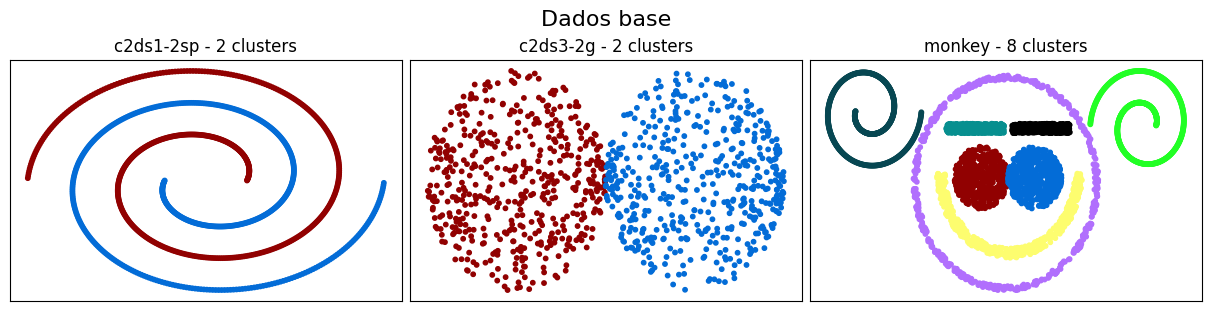

In [3]:
c2ds1_dataset = load_dataset('c2ds1-2sp', '.txt', 1)
c2ds3_dataset = load_dataset('c2ds3-2g', '.txt', 1)
monkey_dataset = load_dataset('monkey', '.txt', 1)
datasets = [c2ds1_dataset, c2ds3_dataset, monkey_dataset]

c2ds1_real = load_dataset('c2ds1-2spReal', '.clu', 0)
c2ds3_real = load_dataset('c2ds3-2gReal', '.clu', 0)
monkey_real = load_dataset('monkeyReal1', '.clu', 0)
reals = [c2ds1_real, c2ds3_real, monkey_real]

plot_multiple_datasets(datasets, 1, 3, reals, 'Dados base')

___
## 2. __Algoritmos__

### __2.1 K-MÉDIAS__

```k_medias(dataset, iterations, clusters)```

Utilizado para gerar um arquivo contendo os clusters gerados
- ```Parâmetros:```
  - dataset: nome do arquivo que contêm as amostras
  - iterations: quantidade de iterations do algoritmo
  - clusters: quantidade de clusters requeridos
- ```Saída:``` nome do arquivo que contêm os clusters gerados

In [4]:
def k_medias(dataset, iterations, clusters):
    # Primeiramente, faz-se uma verificação para k (o número de clusters que será alcançado), para o número de iterações e para o dataset.
    # Se o número de clusters for negativo, o programa imprime o erro e fecha.
    try:
        if clusters <= 0:
            raise ValueError("The parameter 'clusters' must be a numeric value greater than 0")
    except ValueError as e:
        print(e)
        exit(1)
    
    # Se o número de iterações é menor ou igual a zero, o programa imprime o erro e fecha
    try:
        if iterations <= 0:
            raise ValueError("The parameter 'iterations' must be a numeric value greater than 0")
    except ValueError as e:
        print(e)
        exit(1)
        
    # Se não há o dataset no caminho especificado, o programa imprime o erro e fecha.
    try:
        if not os.path.exists(f'dados_e_planilha/datasets/{dataset}'):
            raise FileNotFoundError(f'No such file named {dataset}, it must be a txt file (do not forget the extension)')
    except FileNotFoundError as e:
        print(e)
        exit(1)

    # Leitura do arquivo de dados e salvando o número total de amostras 
    dataframe = pd.read_csv(f'dados_e_planilha/datasets/{dataset}', sep='\t', header=None, names=['Sample', 'A1', 'A2'], skiprows=1)
    numSamples = dataframe.shape[0]

    
    # Se existem mais amostras do que clusters, o programa imprime o erro e fecha
    try:
        if clusters > numSamples:
            raise ValueError(f'There are more clusters than samples, the number of clusters must be equal or lower than {numSamples}')
    except ValueError as e:
        print(e)
        exit(1)

    # Lista que servirá para salvar os centroids
    centroids = []
    # Divisão inteira que representa quantas amostras vão ser usadas inicialmente para cada centroid
    numSamplesPerInitialCentroid = numSamples // clusters

    # Para a quantidade inicial de clusters. dividi-se de maneira igualitátia as amostras e os centroids são calculados pelas médias dos atributos
    for i in range(clusters):
        meanA1 = 0
        meanA2 = 0

        for j in range(numSamplesPerInitialCentroid):
            index = i * numSamplesPerInitialCentroid + j
            meanA1 += dataframe.loc[index]['A1']
            meanA2 += dataframe.loc[index]['A2']

        meanA1 /= numSamplesPerInitialCentroid
        meanA2 /= numSamplesPerInitialCentroid

        centroidName = 'C'+ f'{i}'
        centroids.append((centroidName, meanA1, meanA2))

    
    # Lista de listas para salvar as distâncias euclidianas
    euclideanDistances = [[] for _ in range(clusters)]
    # Lista para salvar as menores distâncias euclidianas
    lowerEuclideanDistances = []

    for i in range(iterations):

        # Limpa as listas (útil quando iterations > 1)
        for j in range(clusters):
            euclideanDistances[j].clear()
        lowerEuclideanDistances.clear()

        # Calculando a distância euclidiana de todas as amostras com todos os centroids
        for idx, centroid in enumerate(centroids):
            valuesCentroid = (centroid[1], centroid[2])
            for k in range(numSamples):
                valuesSample = (dataframe.loc[k]['A1'], dataframe.loc[k]['A2'])
                distance = euclidean(valuesCentroid, valuesSample)
                euclideanDistances[idx].append(distance)

        # Pegando a menor distância euclidiana de uma amostra com os centroids
        for j in range(numSamples):
            lowerDistancesToCentroids = min(range(clusters), key=lambda i: euclideanDistances[i][j])
            lowerEuclideanDistances.append(lowerDistancesToCentroids)

        # Limpa a lista de centroids
        centroids.clear()
        
        # Calcula-se os novos centroides
        for j in range(clusters):
            meanA1 = 0
            meanA2 = 0
            counter = lowerEuclideanDistances.count(j)
            for k in range(numSamples):
                if lowerEuclideanDistances[k] == j:
                    meanA1 += dataframe.loc[k]['A1']
                    meanA2 += dataframe.loc[k]['A2']

            if counter == 0:
                centroidName = 'C'+ f'{j}'
                centroids.append((centroidName, meanA1, meanA2))
            else:
                meanA1 /= counter
                meanA2 /= counter

                centroidName = 'C'+ f'{j}'
                centroids.append((centroidName, meanA1, meanA2))


    # Adiciona o resultado a um dataframe
    resultDataframe = pd.DataFrame({
        'sample_label': dataframe['Sample'],
        'centroid_index': lowerEuclideanDistances
    })

    # Escreve o resultado em um arquivo
    outputFile = 'k_medias_nivel' + str(clusters) + '_' + dataset[:-3] + 'clu'
    resultDataframe.to_csv(f'dados_e_planilha/datasets/{outputFile}', sep='\t', index=False, header=False)

    # Retorna o nome do arquivo do resultado
    return outputFile

### __2.2 SINGLE_LINK__

```single_link(dataset, kmin, kmax)```

Utilizado para gerar um arquivo contendo os clusters gerados
- ```Parâmetros:```
  - dataset: nome do arquivo que contêm as amostras
  - kmin: quantidade mínima de clusters requeridos
  - kmax: quantidade máxima de clusters requeridos
- ```Saída:``` lista que contêm os nomes dos arquivos gerados, com clusters de kmin até kmax

In [5]:
def single_link(dataset, kmin, kmax):

    #Primeiramente, faz-se uma verificação para k (o número de clusters que será alcançado) e para o dataset.
    #Se o número de clusters for negativo, o programa imprime o erro e fecha.
    #Se o número máximo de clusters for maior do que o número menor de clusters, o programa imprime o erro e fecha
    #Se não há o dataset no caminho especificado, o programa imprime o erro e fecha.
    try:
        if (kmin <= 0 or kmax <= 0) :
            raise ValueError("The parameter kmin or kmax must be a numeric value greater than 0")
    except ValueError as e:
        print(e)
        exit(1)
        
    try:
        if (kmin >= kmax) :
            raise ValueError("The parameter kmax must be greater than kmin")
    except ValueError as e:
        print(e)
        exit(1)
            
    try:
        if not os.path.exists(f'dados_e_planilha/datasets/{dataset}'):
            raise FileNotFoundError(f'No such file named {dataset}, it must be a txt file (do not forget the extension)')
    except FileNotFoundError as e:
        print(e)
        exit(1)

    #base é necessário para o output: cada execução de single_link retorna um arquivo contendo a base de dados
    #dividida em k partições, mas ele possui dataframes para todos os k níveis do dendrograma, sendo a partição[5] com 4000-5 clusters (no caso do macaco) .
    #Para retornar apenas o nível k, fazemos base-i, sendo i a i-ésima partição da lista de partições geradas.
    #datasetR é construído, também, para ter o nome do arquivo contendo as partições reais da base de dados.
    if (dataset.startswith('monkey')):
        base = 4000
        datasetR = dataset[:-4] + f'Real1.clu'
    else:
        base = 1000
        datasetR = dataset[:-4] + f'Real.clu'

    #Carregamos o dataframe contendo o dataset a ser analisado.
    '''dataframe = pd.read_csv(
        f'https://raw.githubusercontent.com/Rodinez/IA_2024_1/main/src/dados_e_planilha/datasets/{dataset}', sep='\t',
        header=None, names=['Sample', 'A1', 'A2'], skiprows=1)'''

    # para testar no próprio pc
    dataframe = pd.read_csv(f'dados_e_planilha/datasets/{dataset}', sep='\t', header=None, names=['Sample', 'A1', 'A2'], skiprows=1)

    #numSamples contém o número de linhas do dataframe
    numSamples = dataframe.shape[0]

    #Se o número de clusters pretendido é maior que o número de elementos do dataframe, retornamos o erro e encerramos o programa.
    try:
        if kmin > numSamples or kmax > numSamples:
            raise ValueError(
                f'There are more clusters than samples, the number of clusters must be equal or lower than {numSamples}')
    except ValueError as e:
        print(e)
        exit(1)

    #Gerará partições somente até a partição que se deseja (k)
    numero_clusters_min = kmin  # este numero varia dentro de um espectro

    # converte o dataframe para um vetor de pontos 2D numpy
    # o vetor possui as coordenadas dos objetos do dataset
    lista_pontos_a = dataframe[['A1', 'A2']]  # pega os pontos das colunas A1 e A2 apenas (que contém as coordenadas dos objetos)
    lista_pontos = lista_pontos_a.to_numpy()

    # distancias é uma matriz 2D com a distancia entre todos os pares de pontos
    # calculamos a distância entre cada par de pontos da lista_pontos, e então, convertemos esse array para uma matriz
    # na matriz, a posição distâncias[4][10] terá a distância entre o objeto 4 e o 10.
    distancias = sp.distance.squareform(sp.distance.pdist(lista_pontos))

    # preenche a diagonal de distancias com um numero infinito e depois calcula os minimos da matriz
    # faz-se isso para que o que antes era 0 (distancia de um objeto a ele mesmo) não seja considerado distância mínima
    np.fill_diagonal(distancias, np.inf)

    # clusters é um vetor que cada celula é uma lista com um ponto da base de dados
    # basicamente, guarda quais objetos fazem parte de quais clusters
    # em cluster[4], temos uma lista dos pontos/objetos que fazem parte do cluster 4.
    # No começo, cada objeto faz parte de um cluster diferente. Assim o objeto 0 faz parte do cluster 0, e assim por diante.
    # cluster = [[dado1], [dado2], ..., [dadoN]]
    clusters = [[i] for i in range(len(lista_pontos))]

    # cria uma matriz 3D. Cada matriz 2D dentro dessa matriz 3D é um estado do dendograma (ou seja, contem as combinações entre clusters)
    outputFile_list = []
    dataframe_list = []

    # a primeira matriz tem todos os clusters (primeira partição)
    # sample_label será o nome do cluster (no caso, estamos aproveitando que o nome do cluster -> obj1 se torna cluster 1 ...)
    # partition será os objetos do clusters em string separados por vírgula
    # uma linha do dataframe será, por exemplo:   c2sp1s1   0,2,40,45,20,11
    resultDataframe = pd.DataFrame({
        'sample_label': dataframe['Sample'],
        'partition': pd.Series(clusters).apply(lambda x: ','.join(map(str, x)))
    })

    #dataframe_list contém os níveis do dendrograma
    #assim, em dataframe_list[0], temos o MOMENTO 0, inicial, com todos os objetos em seus clusters distintos.
    dataframe_list.append(resultDataframe)

    #salvamos o nome do arquivo com o estado do dendrograma e colocamos esse nome na lista de arquivos de saída.
    outputFile = dataset[:-3] + 'clu'
    outputFile_list.append(outputFile)

    # pega o min de cada linha e coloca em um vetor a coluna do minimo dessa linha
    matriz_particoes = []
    while len(clusters) > numero_clusters_min:  #Para quando atingirmos o número de clusters da entrada (começa com 1000/4000 clusters e vai diminuindo até k)
        dist_min = np.inf
        juntar_cluster = (0, 0)

        #para cada linha 'i' da matriz contendo as distancias entre objetos, calcula-se qual o 'j' mais próximo de 'i' e salva-o no array menor_indice.
        #assim, menor_indice[3] contém o índice do objeto dentro da matriz que é mais próximo do objeto 3
        menor_indice = np.array([np.argmin(distancias[i]) for i in range(len(distancias))])
        for i in range(distancias.shape[0]):
            #dis_min_lc contém o valor da menor distância possível do objeto 'i' até outro.
            #Como a cada nível do dendrograma unimos apenas 2 clusters, temos que achar qual a menor distância entre as menores distâncias entre os objetos.
            dist_min_lc = distancias[i][menor_indice[i]]
            if dist_min_lc < dist_min:
                dist_min = dist_min_lc
                juntar_cluster = (i, menor_indice[i])

        #Após iterarmos sobre todas as menores distâncias, achamos a menor distância absoluta entre dois objetos.
        #Então, uni-mos os clusters desses objetos.
        clusters[juntar_cluster[0]].extend(clusters[juntar_cluster[1]])
        #atualiza os menores valores
        distancias = atualiza_distancias(distancias, juntar_cluster,1)
        #remove o cluster que foi juntado
        del clusters[juntar_cluster[1]]
        #remove a distancia que acabamos de encontrar
        distancias = np.delete(distancias, juntar_cluster[1], 1)
        distancias = np.delete(distancias, juntar_cluster[1], 0)
        #coloca os clusters dentro de um vetor de clusters
        matriz_particoes.append([list(cluster) for cluster in clusters])
        

    # Converte as partições em DataFrames e salva-os em uma lista
    for nivel, particao in enumerate(matriz_particoes):
        resultDataframe = pd.DataFrame({
            'sample_label': dataframe['Sample'],
            'partition': pd.Series(particao).apply(lambda x: ','.join(map(str, x)))
        })
        dataframe_list.append(resultDataframe)

    results = []
    # Salva cada DataFrame como um arquivo CSV
    for i in range(base, -1, -1):
        if((base-i) <= kmax and (base-i >= kmin)):
            df = dataframe_list[i]
            dataframeR = pd.read_csv(f'dados_e_planilha/datasets/{datasetR}', sep='\t', header=None, names=['Sample', 'A1'], skiprows=0)
            dataframeR['A1'] = dataframeR.index.map(lambda id: nova_coluna(int(id), df))
            outputFile = 'single_link_nivel' + str((base-i)) + '_' + dataset[:-3] + 'clu'
            results.append(outputFile)
            dataframeR.to_csv(f'dados_e_planilha/datasets/{outputFile}', sep='\t', index=False, header=False)

    return results

### __2.3 COMPLETE_LINK__

```complete_link(dataset, kmin, kmax)```

Utilizado para gerar um arquivo contendo os clusters gerados
- ```Parâmetros:```
  - dataset: nome do arquivo que contêm as amostras
  - kmin: quantidade mínima de clusters requeridos
  - kmax: quantidade máxima de clusters requeridos
- ```Saída:``` lista que contêm os nomes dos arquivos gerados, com clusters de kmin até kmax

In [17]:
def complete_link(dataset, kmin, kmax):
    try:
        if (kmin <= 0 or kmax <= 0) :
            raise ValueError("The parameter kmin or kmax must be a numeric value greater than 0")
    except ValueError as e:
        print(e)
        exit(1)
        
    try:
        if (kmin >= kmax) :
            raise ValueError("The parameter kmax must be greater than kmin")
    except ValueError as e:
        print(e)
        exit(1)
           
    try:
        if not os.path.exists(f'dados_e_planilha/datasets/{dataset}'):
            raise FileNotFoundError(f'No such file named {dataset}, it must be a txt file (do not forget the extension)')
    except FileNotFoundError as e:
        print(e)
        exit(1)


    # para testar no google colab
    '''dataframe = pd.read_csv(
        f'https://raw.githubusercontent.com/Rodinez/IA_2024_1/main/src/dados_e_planilha/datasets/{dataset}', sep='\t',
        header=None, names=['Sample', 'A1', 'A2'], skiprows=1)'''

    # para testar no próprio pc
    dataframe = pd.read_csv(f'dados_e_planilha/datasets/{dataset}', sep='\t', header=None, names=['Sample', 'A1', 'A2'], skiprows=1)
    numSamples = dataframe.shape[0]

    try:
        if kmin > numSamples or kmax > numSamples:
            raise ValueError(
                f'There are more clusters than samples, the number of clusters must be equal or lower than {numSamples}')
    except ValueError as e:
        print(e)
        exit(1)

    if (dataset.startswith('monkey')):
        base = 4000
        datasetR = dataset[:-4] + f'Real1.clu'
    else:
        base = 1000
        datasetR = dataset[:-4] + f'Real.clu'

    numero_clusters_min = kmin  # este numero varia dentro de um espectro

    # converte o dataframe para um vetor de pontos 2D numpy
    lista_pontos_a = dataframe[['A1', 'A2']]  # pega os pontos das colunas A1 e A2 apenas
    lista_pontos = lista_pontos_a.to_numpy()

    # distancias eh uma matriz 2D com a distancia entre todos os pares de pontos
    distancias = sp.distance.squareform(sp.distance.pdist(lista_pontos))
    # preenche a diagonal de distancias com um numero infinito e depois calcula os minimos da matriz
    np.fill_diagonal(distancias, np.inf)

    # clusters eh um vetor que cada celula eh uma lista com um ponto da base de dados
    # cluster = [[dado1], [dado2], ..., [dadoN]]
    clusters = [[i] for i in range(len(lista_pontos))]

    # cria uma matriz 3D. Cada matriz 2D dentro dessa matriz 3D é um estado do dendograma (ou seja, contem as combinações entre clusters)
    outputFile_list = []
    dataframe_list = []
    # a primeira matriz tem todos os cluster (primeria partição)
    resultDataframe = pd.DataFrame({
        'sample_label': dataframe['Sample'],
        'partition': pd.Series(clusters).apply(lambda x: ','.join(map(str, x)))
    })
    dataframe_list.append(resultDataframe)
    outputFile = dataset[:-3] + 'clu'
    outputFile_list.append(outputFile)
    # pega o min de cada linha e coloca em um vetor a coluna do minimo dessa linha
    matriz_particoes = []
    while len(clusters) > numero_clusters_min:
        dist_min = np.inf
        juntar_cluster = (0, 0)

        #pega a coluna do menor elemento de cada linha
        menor_indice = np.array([np.argmin(distancias[i]) for i in range(len(distancias))])
        for i in range(distancias.shape[0]):
            #pega a distancia menor distancia de cada linha e compara qual dela é menor
            dist_min_lc = distancias[i][menor_indice[i]]
            if dist_min_lc < dist_min:
                dist_min = dist_min_lc
                juntar_cluster = (i, menor_indice[i])

        #junta os clusters
        clusters[juntar_cluster[0]].extend(clusters[juntar_cluster[1]])
        #atualiza os menores valores
        distancias = atualiza_distancias(distancias, juntar_cluster,0)
        #remove o cluster que foi juntado
        del clusters[juntar_cluster[1]]
        #remove a distancia que acabamos de encontrar
        distancias = np.delete(distancias, juntar_cluster[1], 1)
        distancias = np.delete(distancias, juntar_cluster[1], 0)
        #coloca os clusters dentro de um vetor de clusters
        matriz_particoes.append([list(cluster) for cluster in clusters])

    # Converte as partições em DataFrames e salva-os em uma lista
    for nivel, particao in enumerate(matriz_particoes):
        resultDataframe = pd.DataFrame({
            'sample_label': dataframe['Sample'],
            'partition': pd.Series(particao).apply(lambda x: ','.join(map(str, x)))
        })
        dataframe_list.append(resultDataframe)

    results = []
    # Salva cada DataFrame como um arquivo CSV
    for i in range(base, -1, -1):
        if((base-i) <= kmax and (base-i >= kmin)):
            df = dataframe_list[i]
            dataframeR = pd.read_csv(f'dados_e_planilha/datasets/{datasetR}', sep='\t', header=None, names=['Sample', 'A1'], skiprows=0)
            dataframeR['A1'] = dataframeR.index.map(lambda id: nova_coluna(int(id), df))
            outputFile = 'complete_link_nivel' + str((base-i)) + '_' + dataset[:-3] + 'clu'
            results.append(outputFile)
            dataframeR.to_csv(f'dados_e_planilha/datasets/{outputFile}', sep='\t', index=False, header=False)

    return results


___
## __3. RESULTADOS__

Os resultados de cada algoritmo será mostrado a seguir, contendo um gráfico para cada partição

### __3.1 K-MÉDIAS__

In [7]:
k_medias_c2ds1 = []
for i in range(2, 6):
    k_medias_c2ds1.append(load_dataset(k_medias('c2ds1-2sp.txt', 5, i), '',0))

k_medias_c2ds3 = []
for i in range(2, 6):
    k_medias_c2ds3.append(load_dataset(k_medias('c2ds3-2g.txt', 5, i), '',0))

k_medias_monkey = []
for i in range(5, 13):
   k_medias_monkey.append(load_dataset(k_medias('monkey.txt', 5, i), '',0))

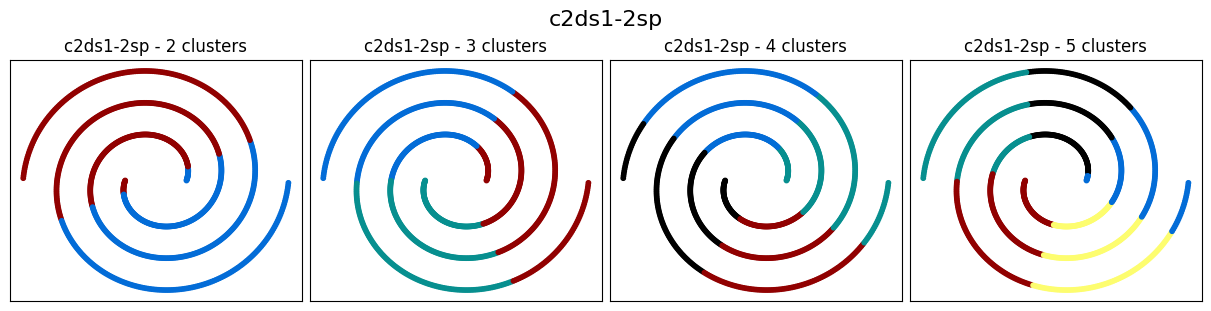

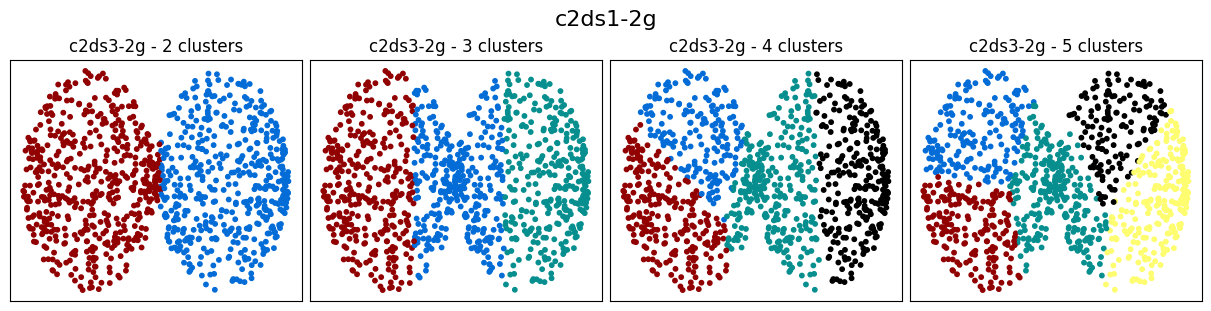

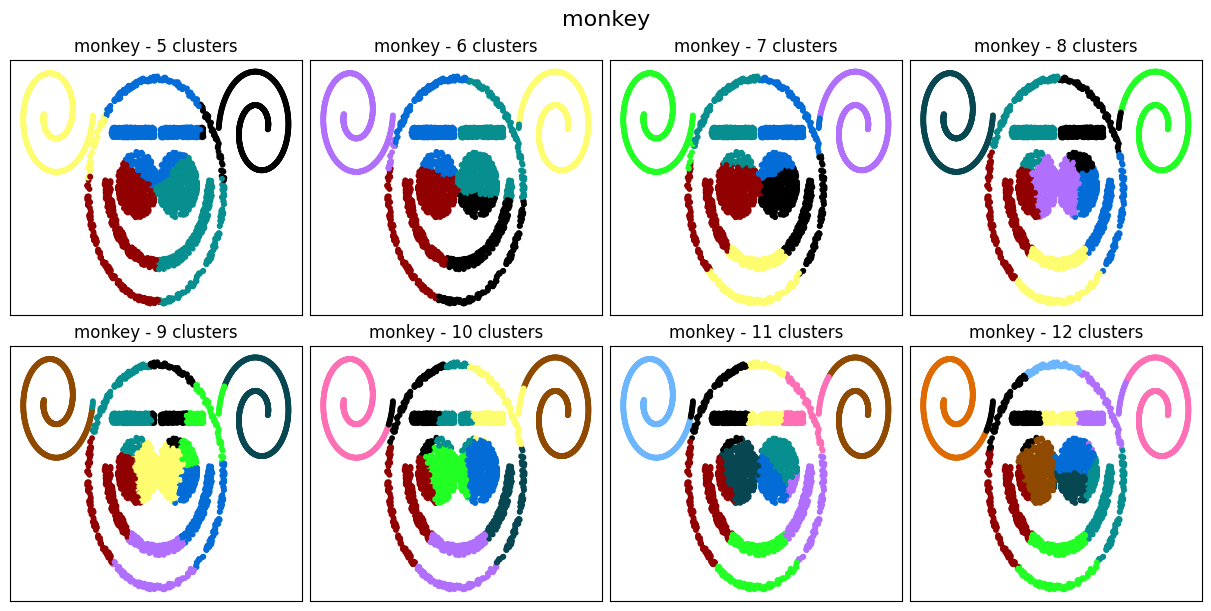

In [8]:
plot_multiple_partitions(c2ds1_dataset, k_medias_c2ds1, 1, 4, 'c2ds1-2sp')
plot_multiple_partitions(c2ds3_dataset, k_medias_c2ds3, 1, 4, 'c2ds1-2g')
plot_multiple_partitions(monkey_dataset, k_medias_monkey, 2, 4, 'monkey')

## __3.2 SINGLE_LINK__

In [28]:
output = single_link('c2ds1-2sp.txt', 2, 5)
single_link_c2ds1 = []
for idx, item in enumerate(output):
    single_link_c2ds1.append(load_dataset(output[idx], '', 0))

output = single_link('c2ds3-2g.txt', 2, 5)
single_link_c2ds3 = []
for idx, item in enumerate(output):
    single_link_c2ds3.append(load_dataset(output[idx], '', 0))

output = single_link('monkey.txt', 5, 12)
single_link_monkey = []
for idx, item in enumerate(output):
    single_link_monkey.append(load_dataset(output[idx], '', 0))

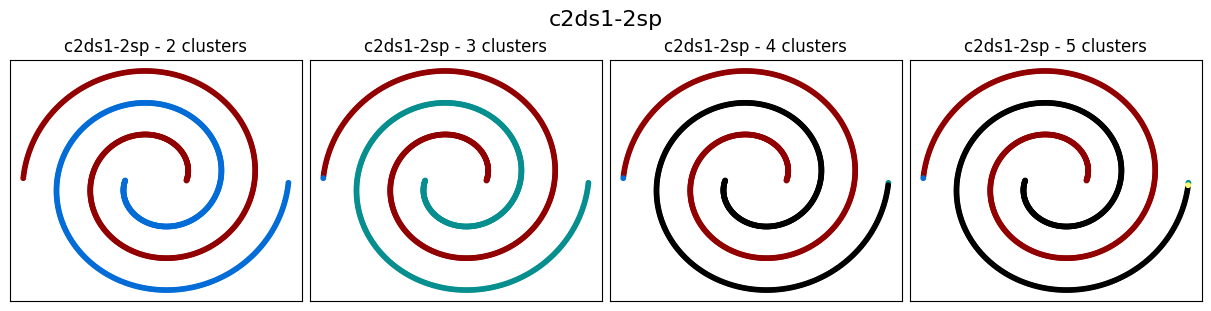

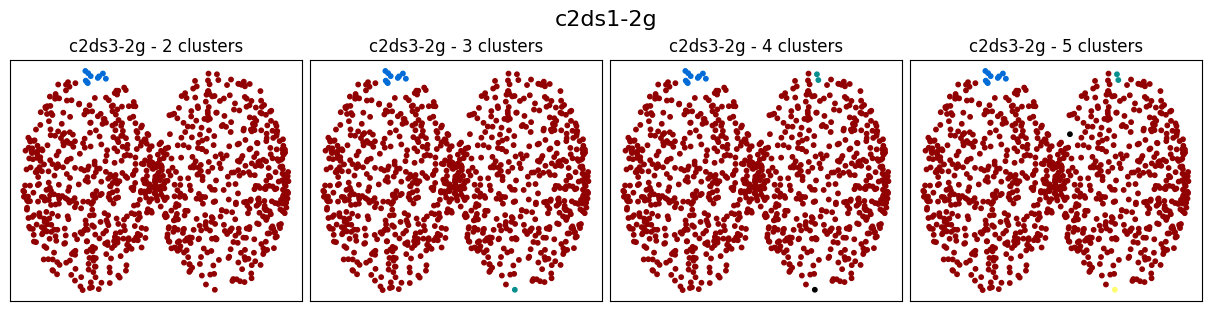

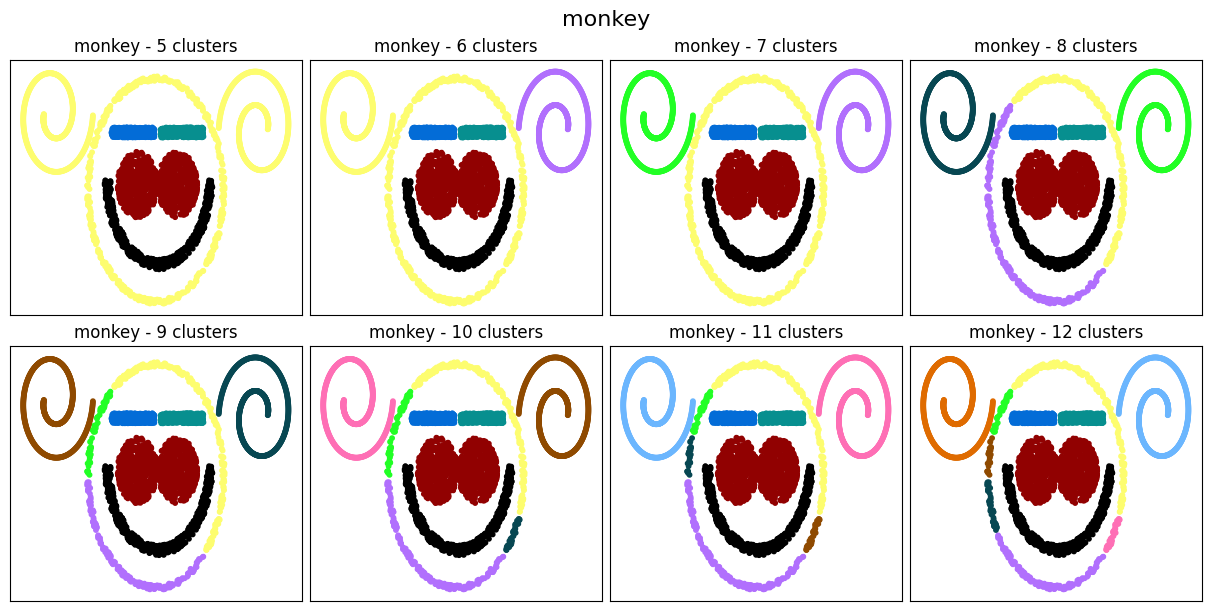

In [10]:
plot_multiple_partitions(c2ds1_dataset, single_link_c2ds1, 1, 4, 'c2ds1-2sp')
plot_multiple_partitions(c2ds3_dataset, single_link_c2ds3, 1, 4, 'c2ds1-2g')
plot_multiple_partitions(monkey_dataset, single_link_monkey, 2, 4, 'monkey')

## __3.3 COMPLETE_LINK__

In [11]:
output = complete_link('c2ds1-2sp.txt', 2, 5)
complete_link_c2ds1 = []
for idx, item in enumerate(output):
    complete_link_c2ds1.append(load_dataset(output[idx], '', 0))

output = complete_link('c2ds3-2g.txt', 2, 5)
complete_link_c2ds3 = []
for idx, item in enumerate(output):
    complete_link_c2ds3.append(load_dataset(output[idx], '', 0))

output = complete_link('monkey.txt', 5, 12)
complete_link_monkey = []
for idx, item in enumerate(output):
    complete_link_monkey.append(load_dataset(output[idx], '', 0))

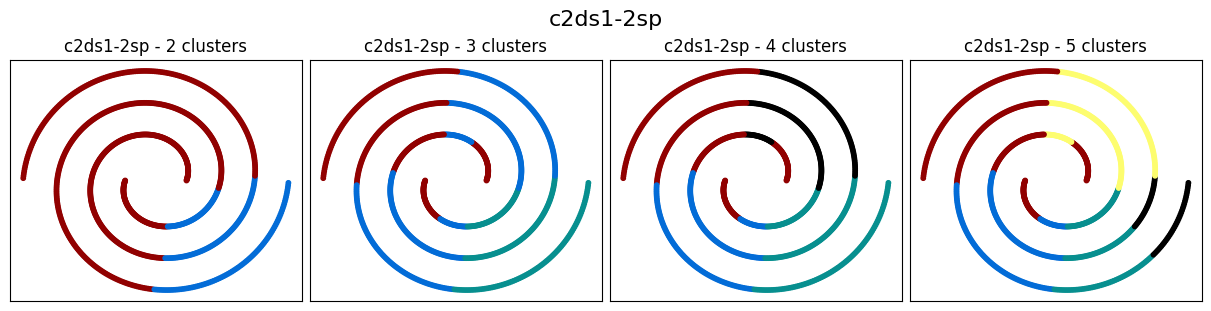

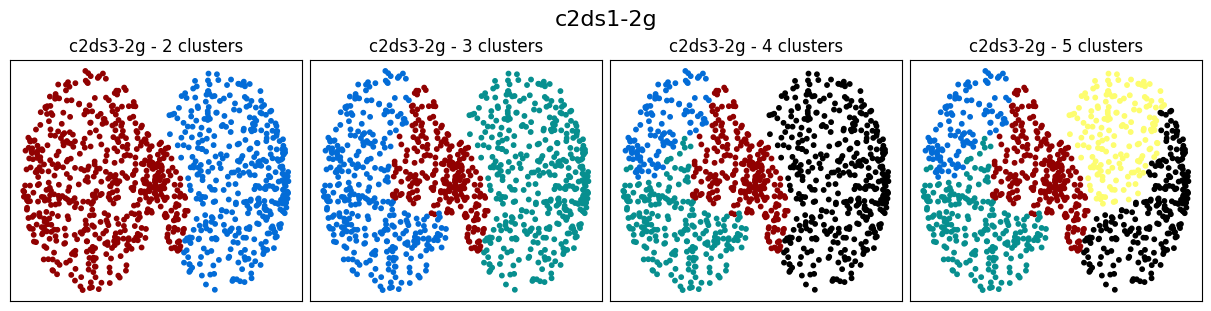

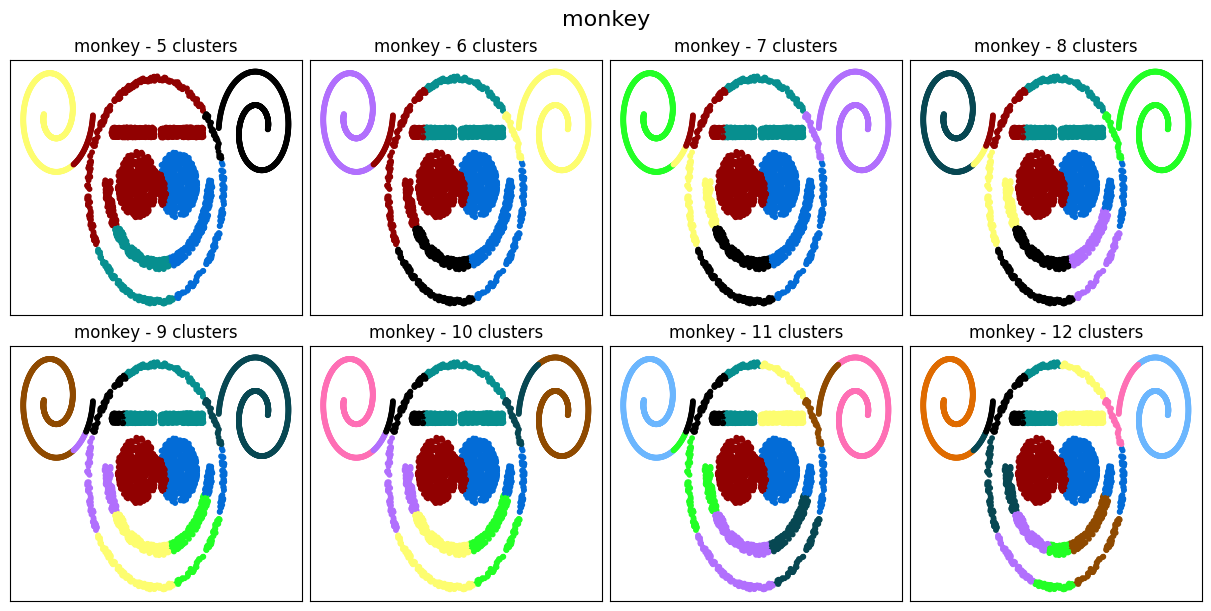

In [12]:
plot_multiple_partitions(c2ds1_dataset, complete_link_c2ds1, 1, 4, 'c2ds1-2sp')
plot_multiple_partitions(c2ds3_dataset, complete_link_c2ds3, 1, 4, 'c2ds1-2g')
plot_multiple_partitions(monkey_dataset, complete_link_monkey, 2, 4, 'monkey')

___
## __4. Índice Rand__

### __4.1 K-MÉDIAS__

In [24]:
rand(k_medias_c2ds1, "c2ds1-2spReal.clu")
rand(k_medias_c2ds3, "c2ds3-2gReal.clu")
rand(k_medias_monkey, "monkeyReal1.clu")

O índice Rand ajustado de 2 clusters comparado com c2ds1-2spReal.clu é 0.05665571142284569
O índice Rand ajustado de 3 clusters comparado com c2ds1-2spReal.clu é 0.047128268199677234
O índice Rand ajustado de 4 clusters comparado com c2ds1-2spReal.clu é 0.027409121470721626
O índice Rand ajustado de 5 clusters comparado com c2ds1-2spReal.clu é 0.03843834091706076
O índice Rand ajustado de 2 clusters comparado com c2ds3-2gReal.clu é 0.9215215687028959
O índice Rand ajustado de 3 clusters comparado com c2ds3-2gReal.clu é 0.440449253483619
O índice Rand ajustado de 4 clusters comparado com c2ds3-2gReal.clu é 0.3700375039221846
O índice Rand ajustado de 5 clusters comparado com c2ds3-2gReal.clu é 0.2749609693836803
O índice Rand ajustado de 5 clusters comparado com monkeyReal1.clu é 0.4327401362553705
O índice Rand ajustado de 6 clusters comparado com monkeyReal1.clu é 0.5292042293474852
O índice Rand ajustado de 7 clusters comparado com monkeyReal1.clu é 0.5997096944279802
O índice Rand a

___
### __4.2 SINGLE_LINK__

In [14]:
rand(single_link_c2ds1, "c2ds1-2spReal.clu")
rand(single_link_c2ds3, "c2ds3-2gReal.clu")
rand(single_link_monkey, "monkeyReal1.clu")

O índice Rand ajustado de P2 comparado com c2ds1-2spReal.clu é 1.0
O índice Rand ajustado de P3 comparado com c2ds1-2spReal.clu é 0.998001996003992
O índice Rand ajustado de P4 comparado com c2ds1-2spReal.clu é 0.996003984015936
O índice Rand ajustado de P5 comparado com c2ds1-2spReal.clu é 0.9940099680918327
O índice Rand ajustado de P2 comparado com c2ds3-2gReal.clu é 0.0003603746454814425
O índice Rand ajustado de P3 comparado com c2ds3-2gReal.clu é 0.0003204143703386531
O índice Rand ajustado de P4 comparado com c2ds3-2gReal.clu é 0.00025650970764512287
O índice Rand ajustado de P5 comparado com c2ds3-2gReal.clu é 0.00022856122260008724
O índice Rand ajustado de P5 comparado com monkeyReal1.clu é 0.5995794532892761
O índice Rand ajustado de P6 comparado com monkeyReal1.clu é 0.764390502562894
O índice Rand ajustado de P7 comparado com monkeyReal1.clu é 0.8707707222491518
O índice Rand ajustado de P8 comparado com monkeyReal1.clu é 0.8344550575452158
O índice Rand ajustado de P9 com

___
### __4.3 COMPLETE_LINK__

In [15]:
rand(complete_link_c2ds1, "c2ds1-2spReal.clu")
rand(complete_link_c2ds3, "c2ds3-2gReal.clu")
rand(complete_link_monkey, "monkeyReal1.clu")

O índice Rand ajustado de P2 comparado com c2ds1-2spReal.clu é 0.017803778778480373
O índice Rand ajustado de P3 comparado com c2ds1-2spReal.clu é 0.01722060221752122
O índice Rand ajustado de P4 comparado com c2ds1-2spReal.clu é 0.018075613800582997
O índice Rand ajustado de P5 comparado com c2ds1-2spReal.clu é 0.017007219550904694
O índice Rand ajustado de P2 comparado com c2ds3-2gReal.clu é 0.6622696273747208
O índice Rand ajustado de P3 comparado com c2ds3-2gReal.clu é 0.568742416255306
O índice Rand ajustado de P4 comparado com c2ds3-2gReal.clu é 0.4664096517341555
O índice Rand ajustado de P5 comparado com c2ds3-2gReal.clu é 0.30635247514393954
O índice Rand ajustado de P5 comparado com monkeyReal1.clu é 0.3198400185968395
O índice Rand ajustado de P6 comparado com monkeyReal1.clu é 0.48252515404099794
O índice Rand ajustado de P7 comparado com monkeyReal1.clu é 0.5234281325725679
O índice Rand ajustado de P8 comparado com monkeyReal1.clu é 0.5485186781011244
O índice Rand ajusta